# Classification Expectation Maximization (CEM) Algorithm

This notebook demonstrates the **Classification EM (CEM) algorithm** and compares it with the standard **Expectation Maximization (EM) algorithm** for Gaussian Mixture Models.

## Overview

The CEM algorithm (Celeux and Govaert, 1992) is a variant of the EM algorithm that incorporates a **classification step (C-step)** between the E-step and M-step. This modification aims to maximize the **classification likelihood** rather than the traditional likelihood.

### CEM Algorithm Steps:

1. **E-step**: Calculate conditional probabilities $\tau_{ig}^{(r)}$ that observation $y_i$ belongs to cluster $g$
2. **C-step**: Assign each observation to one cluster using the MAP (Maximum A Posteriori) operator:
   $$z_{ig}^{(r+1)} = \begin{cases} 1 & \text{if } g = \arg\max_g \tau_{ig}^{(r)} \\ 0 & \text{otherwise} \end{cases}$$
3. **M-step**: Update parameters by maximizing the complete-data log-likelihood $L_C(\theta; y, z^{r+1})$

### Key Properties:

- **K-means-like**: Produces hard assignments rather than soft probabilistic assignments
- **Biased estimates**: Maximizes complete-data likelihood $L_C(\theta)$ rather than actual likelihood $L(\theta)$
- **Fast convergence**: CEM generally converges faster and is therefore computationally more efficient

### When to Use CEM:

- **Well-separated clusters**: When mixture components are well separated with similar proportions
- **Fast clustering**: When computational speed is more important than maximum likelihood estimates
- **Initialisation**: Can be used as an alternative initialisation if kmeans does not perform well

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import seaborn as sns
from tqdm.notebook import tqdm

import os
os.chdir('../')

from tgmm import GMMInitializer, dynamic_figsize, plot_gmm, GaussianMixture

# Set random seed for reproducibility
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)

# Check for GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if device == 'cuda':
    torch.cuda.manual_seed(random_state)
    print('CUDA version:', torch.version.cuda)
    print('Device:', torch.cuda.get_device_name(0))

Using device: cuda
CUDA version: 12.4
Device: NVIDIA GeForce RTX 4060 Laptop GPU


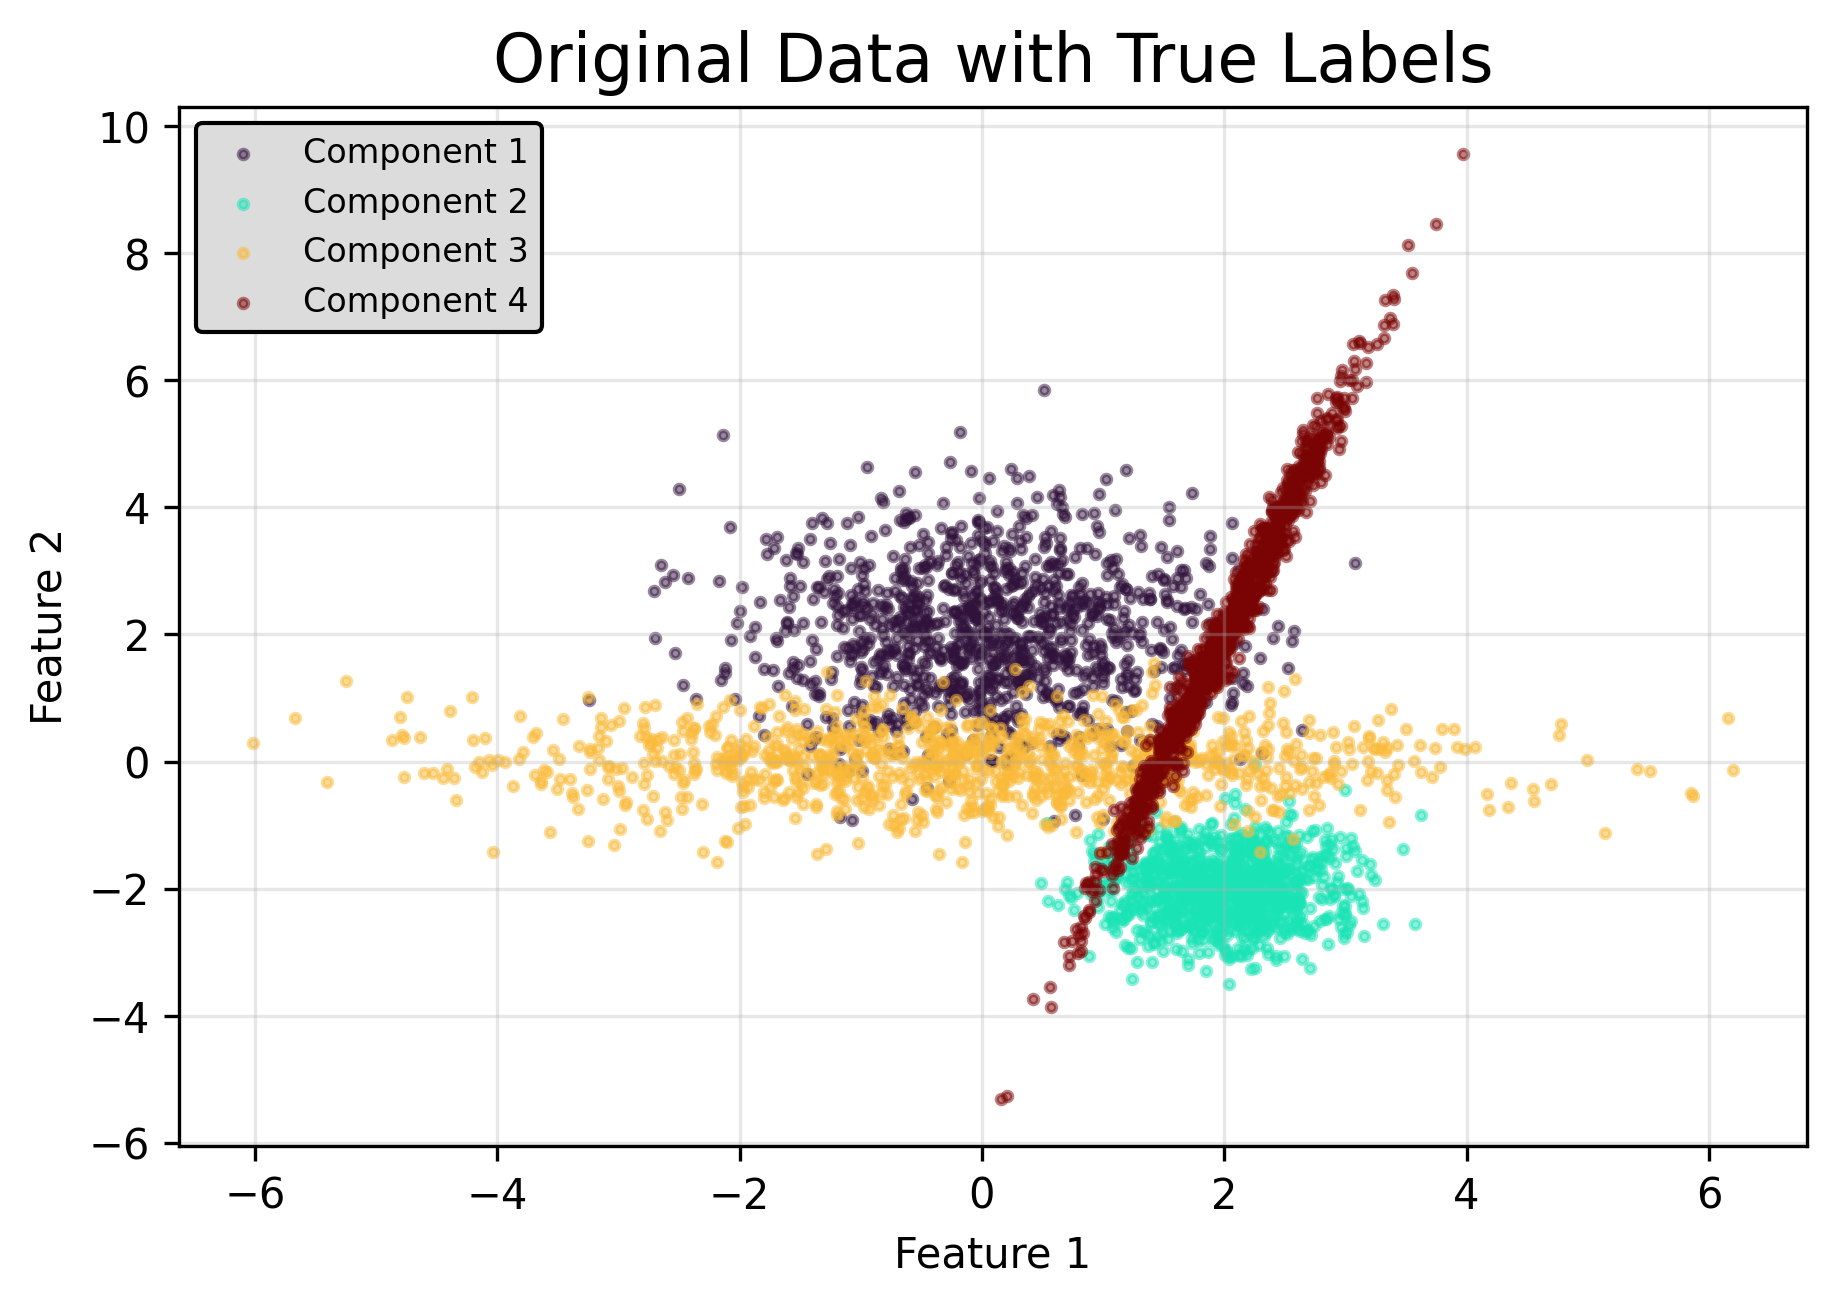

In [14]:
n_samples = [1000, 1000, 1000, 1000]
centers = [np.array([0, 2]),
           np.array([2, -2]),
           np.array([0, 0]),
           np.array([2, 2])]
covs = [
    1.0 * np.eye(2),                    # spherical covariance
    0.5 * np.eye(2),                    # spherical covariance, fewer points
    np.array([[2, 0], [0, 0.5]]),       # diagonal covariance
    np.array([[0.2, 0.5], [0.5, 2]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]

n_features = X.shape[1]
n_components = len(n_samples)

# Convert to tensor (if needed for further processing)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

plot_gmm(X=X, true_labels=labels, title='Original Data with True Labels', legend_labels=legend_labels)
plt.show()

## Experiment 1: Overlapping Clusters

In this first experiment, we create **overlapping clusters** with varying sample sizes and covariance structures:

- **Component 1**: 1000 samples, spherical covariance (σ² = 1.0)
- **Component 2**: 1000 samples, spherical covariance (σ² = 0.5) 
- **Component 3**: 1000 samples, diagonal covariance
- **Component 4**: 1000 samples, full covariance with correlation

This scenario tests how EM vs CEM handle **ambiguous cluster boundaries** where observations could reasonably belong to multiple clusters.

In [15]:
def fit_and_evaluate_gmm(X_tensor, n_components, covariance_type='full', cem=False, random_state=1, iters=20):
    """Fit a GMM with either EM or CEM and return the model and timing."""
    
    average_time = 0
    average_iters = 0
    average_log_likelihood = 0
    
    for i in range(iters):
        # Initialize the GMM
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            tol=1e-10,
            reg_covar=1e-6,
            max_iter=1000,
            init_params='points',
            random_state=random_state + i,  # Different seed for each iteration
            device=device,
            cem=cem  # Toggle between EM and CEM
        )
        
        # Time the fitting process
        start_time = time.time()
        gmm.fit(X_tensor)
        end_time = time.time()

        average_time += (end_time - start_time)
        average_iters += gmm.n_iter_
        average_log_likelihood += gmm.lower_bound_

        print(f"Iteration {i+1}/{iters} - Log-likelihood: {gmm.lower_bound_:.4f}, Iterations: {gmm.n_iter_}, Time: {end_time - start_time:.4f}s")

    return gmm, average_time / iters, average_iters / iters, average_log_likelihood / iters

# Fit both models
print("Fitting GMM using standard EM algorithm...")
gmm_em, time_em, iters_em, log_likelihood_em = fit_and_evaluate_gmm(X_tensor, n_components, cem=False, random_state=random_state)


Fitting GMM using standard EM algorithm...
Iteration 1/20 - Log-likelihood: -3.2424, Iterations: 57, Time: 0.0640s
Iteration 2/20 - Log-likelihood: -3.2424, Iterations: 65, Time: 0.0686s
Iteration 3/20 - Log-likelihood: -3.2424, Iterations: 65, Time: 0.0761s
Iteration 4/20 - Log-likelihood: -3.2424, Iterations: 133, Time: 0.1328s
Iteration 5/20 - Log-likelihood: -3.2424, Iterations: 37, Time: 0.0388s
Iteration 3/20 - Log-likelihood: -3.2424, Iterations: 65, Time: 0.0761s
Iteration 4/20 - Log-likelihood: -3.2424, Iterations: 133, Time: 0.1328s
Iteration 5/20 - Log-likelihood: -3.2424, Iterations: 37, Time: 0.0388s
Iteration 6/20 - Log-likelihood: -3.2424, Iterations: 50, Time: 0.0523s
Iteration 7/20 - Log-likelihood: -3.2424, Iterations: 44, Time: 0.0456s
Iteration 8/20 - Log-likelihood: -3.2424, Iterations: 103, Time: 0.1030s
Iteration 6/20 - Log-likelihood: -3.2424, Iterations: 50, Time: 0.0523s
Iteration 7/20 - Log-likelihood: -3.2424, Iterations: 44, Time: 0.0456s
Iteration 8/20 - L

In [16]:
print("\nFitting GMM using Classification EM (CEM) algorithm...")
gmm_cem, time_cem, iters_cem, log_likelihood_cem = fit_and_evaluate_gmm(X_tensor, n_components, cem=True)



Fitting GMM using Classification EM (CEM) algorithm...
Iteration 1/20 - Log-likelihood: -3.3384, Iterations: 35, Time: 0.0448s
Iteration 2/20 - Log-likelihood: -3.3554, Iterations: 31, Time: 0.0358s
Iteration 3/20 - Log-likelihood: -3.3488, Iterations: 18, Time: 0.0226s
Iteration 4/20 - Log-likelihood: -3.6491, Iterations: 21, Time: 0.0286s
Iteration 5/20 - Log-likelihood: -3.3152, Iterations: 23, Time: 0.0265s
Iteration 4/20 - Log-likelihood: -3.6491, Iterations: 21, Time: 0.0286s
Iteration 5/20 - Log-likelihood: -3.3152, Iterations: 23, Time: 0.0265s
Iteration 6/20 - Log-likelihood: -3.3612, Iterations: 31, Time: 0.0521s
Iteration 7/20 - Log-likelihood: -3.6692, Iterations: 12, Time: 0.0358s
Iteration 6/20 - Log-likelihood: -3.3612, Iterations: 31, Time: 0.0521s
Iteration 7/20 - Log-likelihood: -3.6692, Iterations: 12, Time: 0.0358s
Iteration 8/20 - Log-likelihood: -3.7129, Iterations: 52, Time: 0.1253s
Iteration 9/20 - Log-likelihood: -3.3152, Iterations: 19, Time: 0.0348s
Iteratio

In [17]:
# Print basic comparison
print("\n----- Performance Comparison -----")
print(f"EM:  Average Time: {time_em:.3f}s, Average Iterations: {iters_em:.0f}, Best Log-likelihood: {gmm_em.lower_bound_:.3f}, Average Log-likelihood: {log_likelihood_em:.3f}")
print(f"CEM: Average Time: {time_cem:.3f}s, Average Iterations: {iters_cem:.0f}, Best Log-likelihood: {gmm_cem.lower_bound_:.3f}, Average Log-likelihood: {log_likelihood_cem:.3f}")


----- Performance Comparison -----
EM:  Average Time: 0.060s, Average Iterations: 64, Best Log-likelihood: -3.242, Average Log-likelihood: -3.242
CEM: Average Time: 0.050s, Average Iterations: 27, Best Log-likelihood: -3.649, Average Log-likelihood: -3.416


### Results Analysis: Overlapping Clusters

**Expected Behavior with Overlapping Clusters:**

When clusters overlap significantly, we expect to see:
- **CEM converges faster** but achieves **worse likelihood** than EM
- **EM finds better local optima** but requires more iterations
- **CEM's hard assignments** may be suboptimal when cluster boundaries are ambiguous

This matches the theoretical expectation that CEM trades accuracy for speed when dealing with overlapping components.

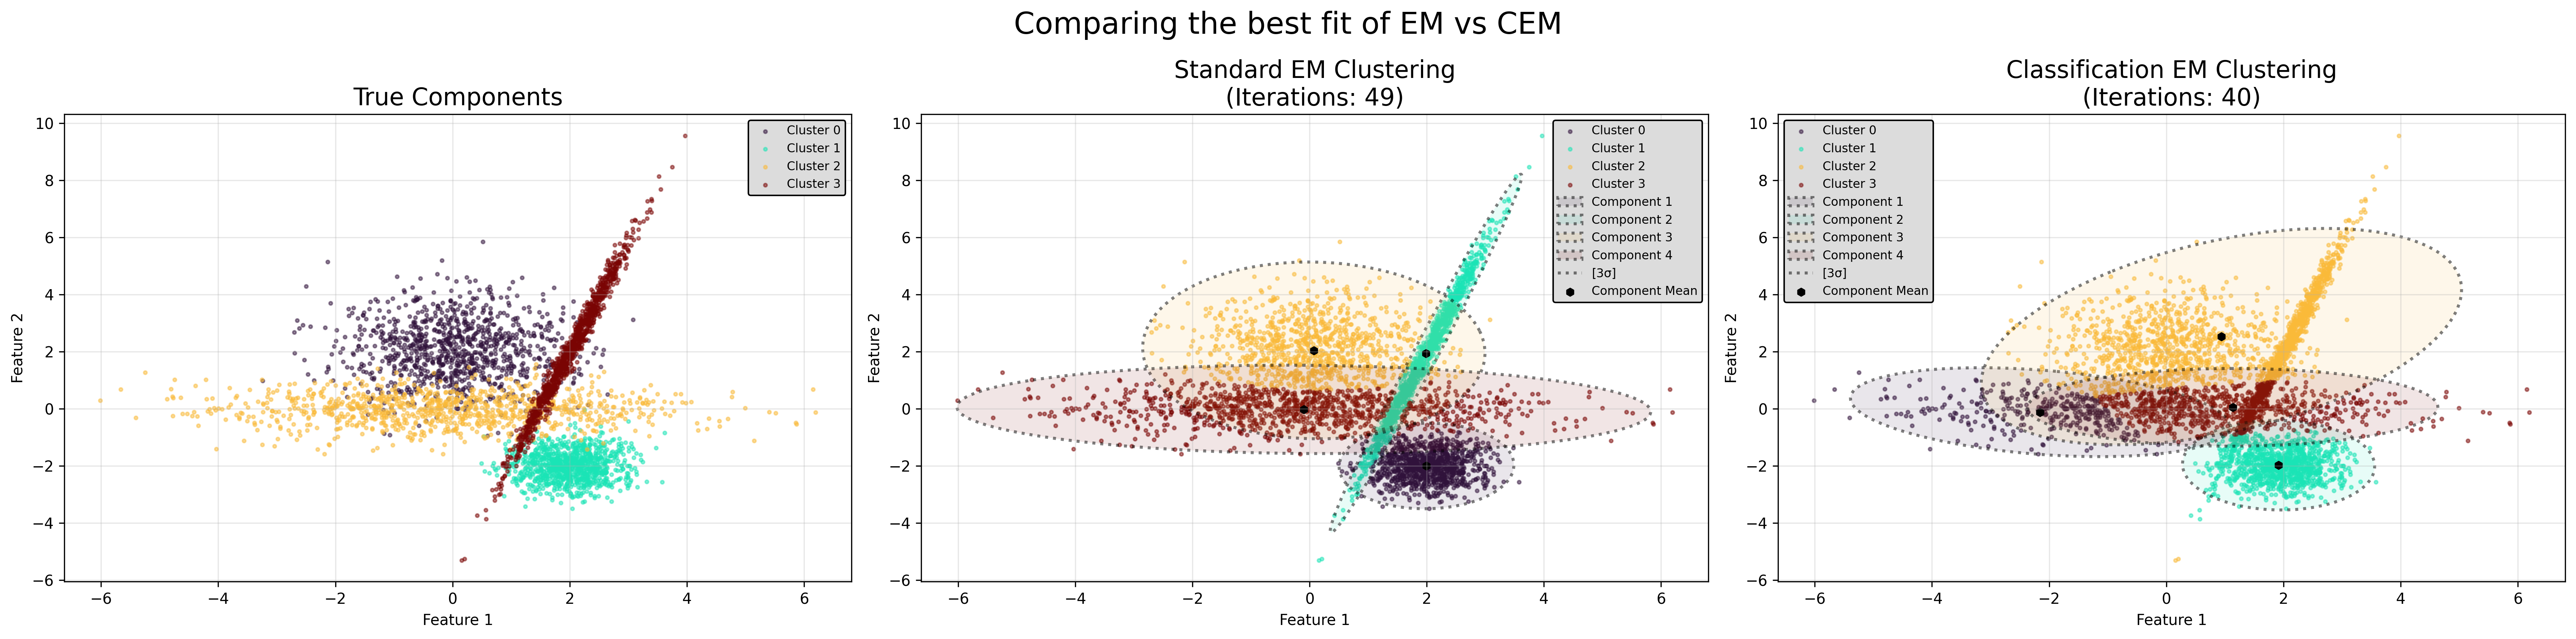

In [18]:
figsize = dynamic_figsize(1, 3)
fig, axes = plt.subplots(1, 3, figsize=figsize)
fig.suptitle('Comparing the best fit of EM vs CEM')

# Plot true labels
plot_gmm(X=X, true_labels=labels, ax=axes[0], title='True Components', 
         show_ellipses=False, show_means=False)

# Plot EM results
plot_gmm(X=X, gmm=gmm_em, ax=axes[1], 
         title=f'Standard EM Clustering\n(Iterations: {gmm_em.n_iter_})',
         color_by_cluster=True, match_labels_to_true=True, ellipse_std_devs=[3], ellipse_fill=True, ellipse_alpha=0.1)

# Plot CEM results  
plot_gmm(X=X, gmm=gmm_cem, ax=axes[2],
         title=f'Classification EM Clustering\n(Iterations: {gmm_cem.n_iter_})',
         color_by_cluster=True, match_labels_to_true=True, ellipse_std_devs=[3], ellipse_fill=True, ellipse_alpha=0.1)

plt.tight_layout()
plt.show()

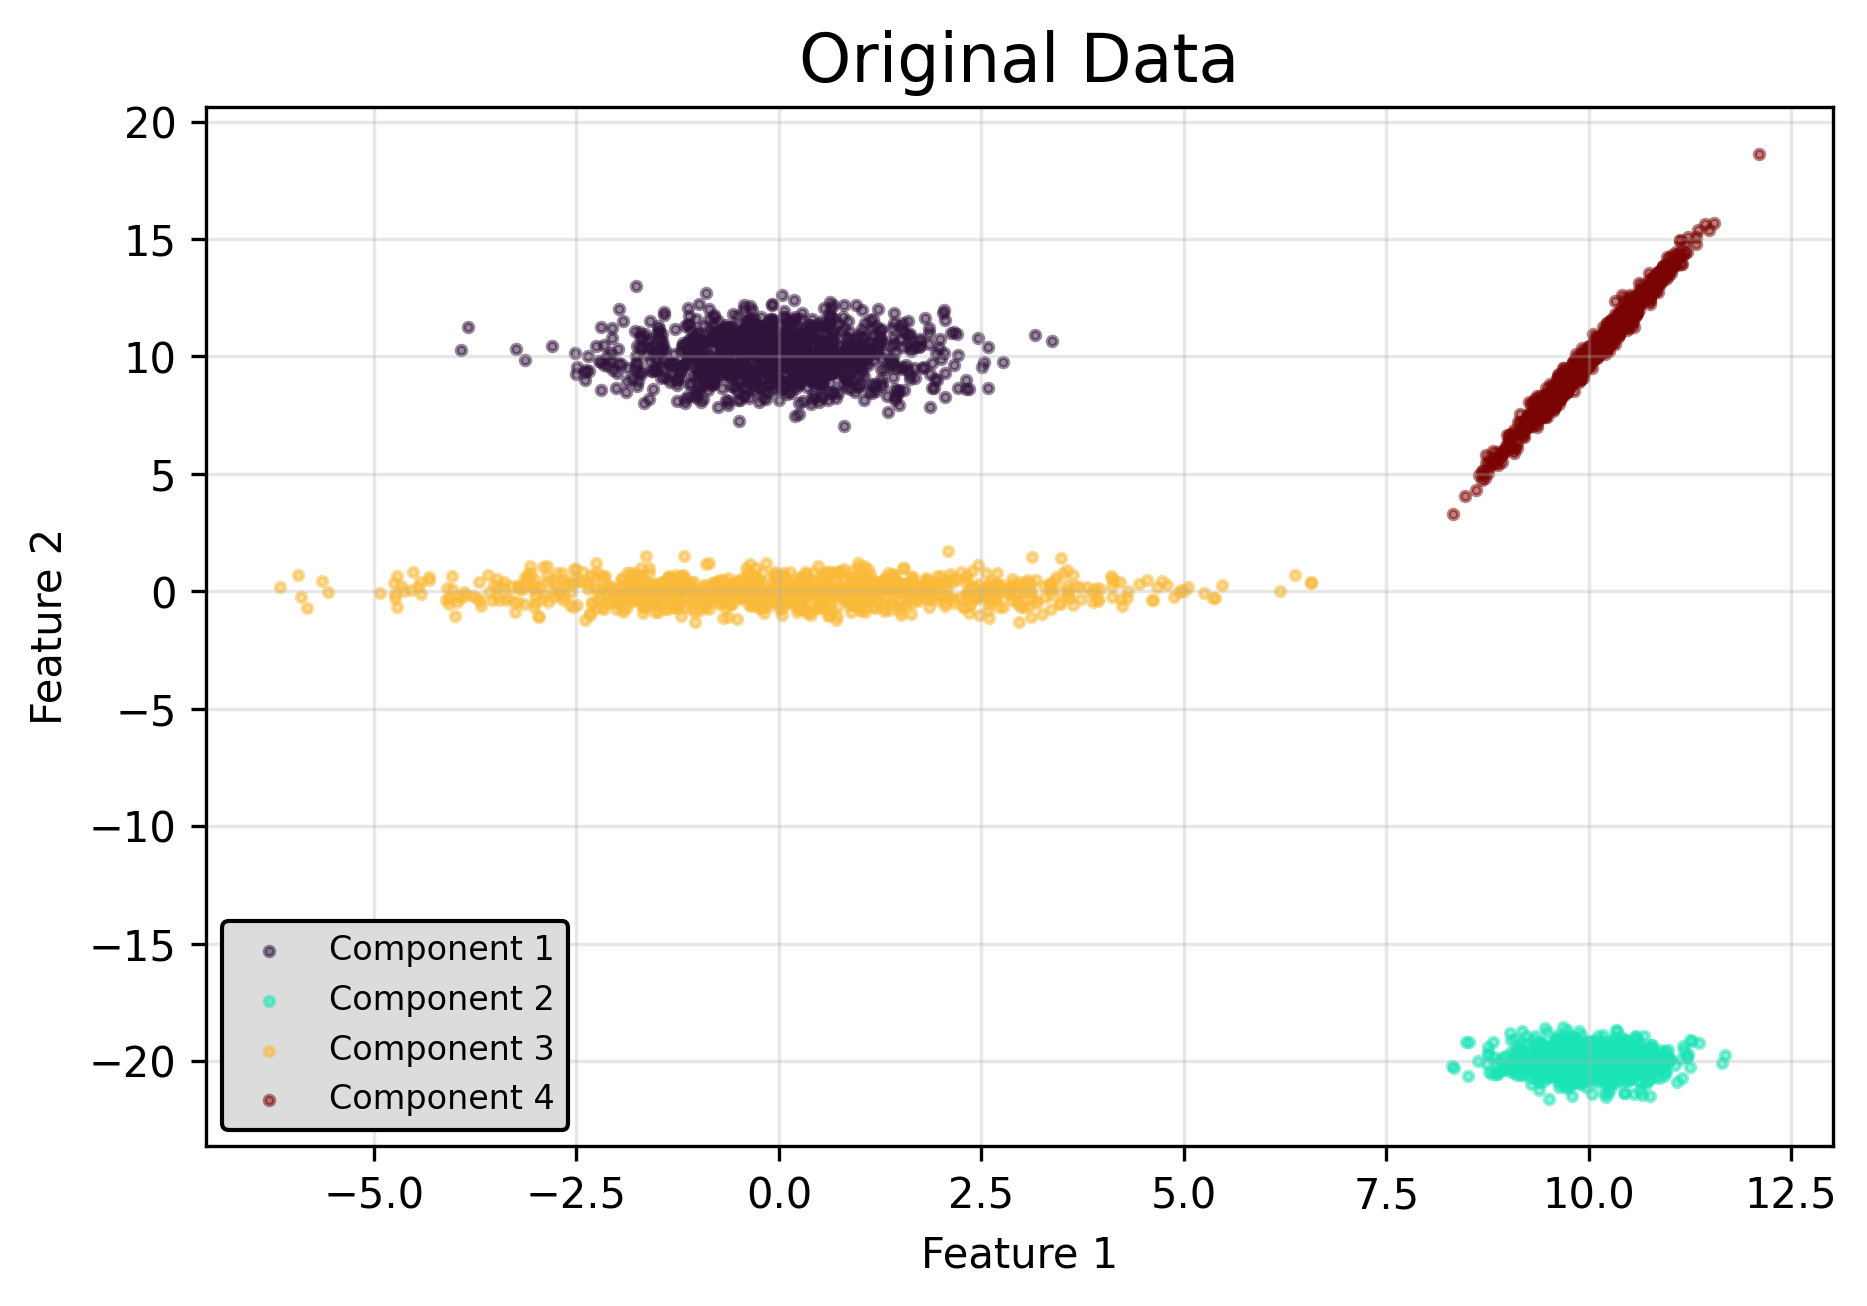

In [19]:
n_samples = [1000, 1000, 1000, 1000]
centers = [np.array([0, 10]),
           np.array([10, -20]),
           np.array([0, 0]),
           np.array([10, 10])]
covs = [
    1.0 * np.eye(2),                    # spherical covariance
    0.5 * np.eye(2),                    # spherical covariance, fewer points
    np.array([[2, 0], [0, 0.5]]),       # diagonal covariance
    np.array([[0.2, 0.5], [0.5, 2]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]

n_features = X.shape[1]
n_components = len(n_samples)

# Convert to tensor (if needed for further processing)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

plot_gmm(X=X, true_labels=labels, title='Original Data', legend_labels=legend_labels)
plt.show()

## Experiment 2: Well-Separated Clusters

In this second experiment, we create **well-separated clusters** by increasing the distance between cluster centers:

- **Component 1**: (0, 10) - far from others
- **Component 2**: (10, -20) - very distant  
- **Component 3**: (0, 0) - origin
- **Component 4**: (10, 10) - well separated

This scenario tests the **ideal case for CEM** where cluster boundaries are clear and unambiguous. According to theory:

> "When the mixture components are well separated with similar proportions, the CEM algorithm is expected to provide a relevant clustering" (Celeux and Govaert, 1992)

**Expected Behavior:**
- **Similar final accuracy** for both EM and CEM
- **CEM converges much faster** due to clear cluster boundaries
- **Hard assignments are optimal** when clusters don't overlap

In [20]:
print("Fitting GMM using standard EM algorithm...")
gmm_em, time_em, iters_em, log_likelihood_em = fit_and_evaluate_gmm(X_tensor, n_components, cem=False)

Fitting GMM using standard EM algorithm...
Iteration 1/20 - Log-likelihood: -4.1160, Iterations: 40, Time: 0.0860s
Iteration 2/20 - Log-likelihood: -4.8963, Iterations: 77, Time: 0.1038s
Iteration 3/20 - Log-likelihood: -5.3390, Iterations: 183, Time: 0.2540s
Iteration 4/20 - Log-likelihood: -4.5743, Iterations: 52, Time: 0.0738s
Iteration 3/20 - Log-likelihood: -5.3390, Iterations: 183, Time: 0.2540s
Iteration 4/20 - Log-likelihood: -4.5743, Iterations: 52, Time: 0.0738s
Iteration 5/20 - Log-likelihood: -5.3390, Iterations: 174, Time: 0.2340s
Iteration 6/20 - Log-likelihood: -3.3993, Iterations: 8, Time: 0.0133s
Iteration 7/20 - Log-likelihood: -4.5742, Iterations: 54, Time: 0.0639s
Iteration 8/20 - Log-likelihood: -4.7658, Iterations: 34, Time: 0.0477s
Iteration 9/20 - Log-likelihood: -4.1174, Iterations: 15, Time: 0.0220s
Iteration 5/20 - Log-likelihood: -5.3390, Iterations: 174, Time: 0.2340s
Iteration 6/20 - Log-likelihood: -3.3993, Iterations: 8, Time: 0.0133s
Iteration 7/20 - Lo

In [21]:
print("\nFitting GMM using Classification EM (CEM) algorithm...")
gmm_cem, time_cem, iters_cem, log_likelihood_cem = fit_and_evaluate_gmm(X_tensor, n_components, cem=True)


Fitting GMM using Classification EM (CEM) algorithm...
Iteration 1/20 - Log-likelihood: -4.1167, Iterations: 40, Time: 0.0810s
Iteration 2/20 - Log-likelihood: -4.8953, Iterations: 18, Time: 0.0282s
Iteration 3/20 - Log-likelihood: -5.3532, Iterations: 9, Time: 0.0181s
Iteration 4/20 - Log-likelihood: -4.5879, Iterations: 11, Time: 0.0190s
Iteration 5/20 - Log-likelihood: -5.3512, Iterations: 22, Time: 0.0398s
Iteration 5/20 - Log-likelihood: -5.3512, Iterations: 22, Time: 0.0398s
Iteration 6/20 - Log-likelihood: -3.3993, Iterations: 10, Time: 0.0204s
Iteration 7/20 - Log-likelihood: -4.5754, Iterations: 19, Time: 0.0359s
Iteration 8/20 - Log-likelihood: -4.7654, Iterations: 55, Time: 0.0843s
Iteration 9/20 - Log-likelihood: -4.1172, Iterations: 10, Time: 0.0172s
Iteration 6/20 - Log-likelihood: -3.3993, Iterations: 10, Time: 0.0204s
Iteration 7/20 - Log-likelihood: -4.5754, Iterations: 19, Time: 0.0359s
Iteration 8/20 - Log-likelihood: -4.7654, Iterations: 55, Time: 0.0843s
Iteration

In [22]:
# Print basic comparison
print("\n----- Performance Comparison -----")
print(f"EM:  Average Time: {time_em:.3f}s, Average Iterations: {iters_em:.0f}, Best Log-likelihood: {gmm_em.lower_bound_:.3f}, Average Log-likelihood: {log_likelihood_em:.3f}")
print(f"CEM: Average Time: {time_cem:.3f}s, Average Iterations: {iters_cem:.0f}, Best Log-likelihood: {gmm_cem.lower_bound_:.3f}, Average Log-likelihood: {log_likelihood_cem:.3f}")


----- Performance Comparison -----
EM:  Average Time: 0.074s, Average Iterations: 55, Best Log-likelihood: -3.399, Average Log-likelihood: -4.163
CEM: Average Time: 0.032s, Average Iterations: 16, Best Log-likelihood: -3.399, Average Log-likelihood: -4.166


### Results Analysis: Well-Separated Clusters

**Key Observations:**

The results confirm the theoretical predictions:
- **CEM achieves similar accuracy** to EM (comparable log-likelihood)
- **CEM converges ~3x faster** (fewer iterations required)
- **Both algorithms find the same global optimum** when clusters are well-separated

This demonstrates the **practical advantage of CEM** in scenarios with clear cluster structure. The hard assignment strategy becomes optimal when cluster boundaries are unambiguous.

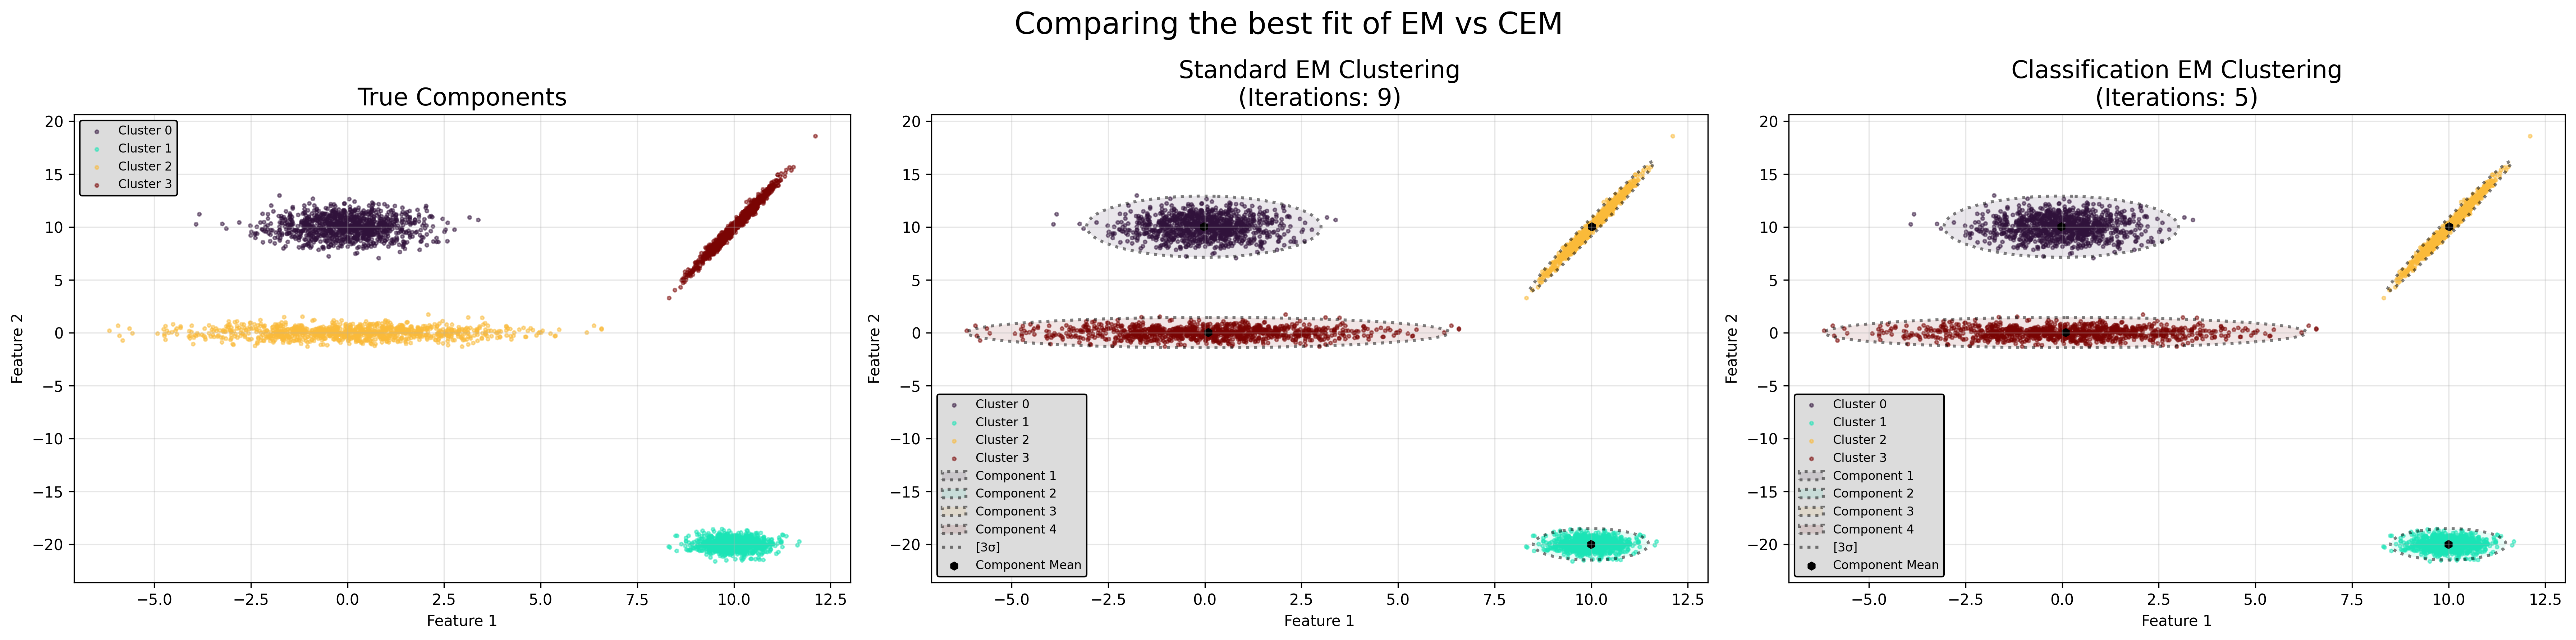

In [23]:
figsize = dynamic_figsize(1, 3)
fig, axes = plt.subplots(1, 3, figsize=figsize)
fig.suptitle('Comparing the best fit of EM vs CEM')

# Plot true labels
plot_gmm(X=X, true_labels=labels, ax=axes[0], title='True Components', 
         show_ellipses=False, show_means=False)

# Plot EM results
plot_gmm(X=X, gmm=gmm_em, ax=axes[1], 
         title=f'Standard EM Clustering\n(Iterations: {gmm_em.n_iter_})',
         color_by_cluster=True, match_labels_to_true=True, ellipse_std_devs=[3], ellipse_fill=True, ellipse_alpha=0.1)

# Plot CEM results  
plot_gmm(X=X, gmm=gmm_cem, ax=axes[2],
         title=f'Classification EM Clustering\n(Iterations: {gmm_cem.n_iter_})',
         color_by_cluster=True, match_labels_to_true=True, ellipse_std_devs=[3], ellipse_fill=True, ellipse_alpha=0.1)

plt.tight_layout()
plt.show()